Given a partner and a hotel, use the model to predict whether there will be reservation call for the next day. The main takeaways are as follows:

 - The model metrics improves w.r.t. more features
 - The final model only blocks 4% of the reservations but block 87% of the zero reservations

### Motivation

Given the cost of the API calls, we would like to investigate the possibility of using machine learning to predict the efficiency of the API calls. As such, we could block the list API calls are unlikely to generate reservation, in order to saving the cost of API calls.

### Data

Due to the large scale of the API dataset, here we did an data undersampling for fast model iterations and better data understanding.

- We pick one partner DESPEGAR.COM
- For DESPEGAR.COM, we randomly sample 1/10 of the hotels, the number of active hotels is 28,473
- Each instance is the daily features for each hotel, we fill all zero for API calls for missing dates
    - from 2017-01-01 to 2017-03-31, the missing date are 275,316 out of 2,562,570, about 10%
- Historical data: from 2015-01-01 to 2017-03-31
- Train instance data: from 2016-01-01 to 2016-12-31, them we undersample the training data to make the dataset balance regarding to the label
- Test instance data: from 2017-01-01 to 2017-03-31

In [1]:
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

try:
    import cPickle as pickle
except:
    import pickle
    
from __future__ import print_function

In [18]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [3]:
def get_preds(model_path, X_test):
    with open(model_path, 'rb') as fin:
        gbm = pickle.load(fin)

    y_preds = gbm.predict(X_test, num_iteration=gbm.best_iteration)
    return y_preds

## feat0 model

3 Features:

 - list_count_sum_365d
 - avail_count_sum_365d
 - res_count_sum_365d

In [ ]:
df_test = pd.read_csv('/Users/fezhao/Projects/traffic_manager/data/test_feat1.csv', sep='|')
df_test.drop(['hotelid', 'request_log_date'], axis=1, inplace=True)

y_test = df_test['label']
X_test = df_test[['list_count_sum_365d', 'avail_count_sum_365d', 'res_count_sum_365d']]

y_pred_feat0 = get_preds('/Users/fezhao/Projects/traffic_manager/data/model_feat0.pkl', X_test)
np.savetxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat0.txt', y_pred_feat0, '%.8f')

## feat1 model

12 Features:

 - list_count_sum_[365d, 30d, 7d, prev]
 - avail_count_sum_[365d, 30d, 7d, prev]
 - res_count_sum_[365d, 30d, 7d, prev]

In [ ]:
df_test = pd.read_csv('/Users/fezhao/Projects/traffic_manager/data/test_feat1.csv', sep='|')
df_test.drop(['hotelid', 'request_log_date'], axis=1, inplace=True)

y_test = df_test['label']
X_test = df_test.drop(['label'], axis=1)

y_pred_feat1 = get_preds('/Users/fezhao/Projects/traffic_manager/data/model_feat1.pkl', X_test)
np.savetxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat1.txt', y_pred_feat1, '%.8f')

## feat2 model

40 Features:

 - list_count_sum_[365d, 30d, 7d, prev]
 - avail_count_sum_[365d, 30d, 7d, prev]
 - res_count_sum_[365d, 30d, 7d, prev]
 - hotelpedia features

In [26]:
df_test = pd.read_csv('/Users/fezhao/Projects/traffic_manager/data/test_feat2.csv', sep='|')
df_test.drop(['hotelid', 'request_log_date', 'tnow_id'], axis=1, inplace=True)

y_test = df_test['label']
X_test = df_test.drop(['label'], axis=1)

y_pred_feat2 = get_preds('/Users/fezhao/Projects/traffic_manager/data/model_feat2.pkl', X_test)
np.savetxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat2.txt', y_pred_feat2, '%.8f')

## feat3 model

60 Features:

 - list_count_sum_[365d, 30d, 7d, prev]
 - avail_count_sum_[365d, 30d, 7d, prev]
 - res_count_sum_[365d, 30d, 7d, prev]
 - hotelpedia features
 - derived features from date: day_of_week, month
 - derived ratio features:
    * avail_list_ratio, res_avail_ratio, res_list_ratio
    * prev_7d_ratio, 7d_30d_ratio, 30d_365d_ratio

In [5]:
df_test = pd.read_csv('/Users/fezhao/Projects/traffic_manager/data/test_feat3.csv', sep='|')
df_test.drop(['hotelid', 'request_log_date', 'tnow_id'], axis=1, inplace=True)

y_test = df_test['label']
X_test = df_test.drop(['label'], axis=1)

y_pred_feat3 = get_preds('/Users/fezhao/Projects/traffic_manager/data/model_feat3.pkl', X_test)
np.savetxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat3.txt', y_pred_feat3, '%.8f')

## Analysis results

In [63]:
y_pred_feat0 = np.loadtxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat0.txt')
y_pred_feat1 = np.loadtxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat1.txt')
y_pred_feat2 = np.loadtxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat2.txt')
y_pred_feat3 = np.loadtxt('/Users/fezhao/Projects/traffic_manager/data/y_pred_feat3.txt')

In [40]:
def show_metrics(y_pred, y_test):
    preds = y_pred >= 0.5
    labels = y_test
    cm = metrics.confusion_matrix(labels, preds)
    print('model log loss:' + str(metrics.log_loss(y_test, y_pred)))
    plot_confusion_matrix(cm, classes=[0,1])

model log loss:0.301645615138


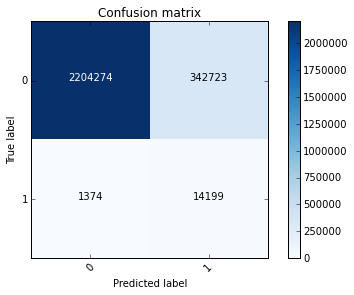

In [41]:
show_metrics(y_pred_feat0, y_test)

model log loss:0.299786225885


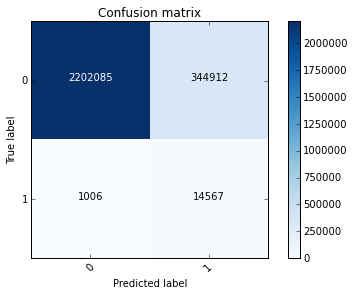

In [42]:
show_metrics(y_pred_feat1, y_test)

model log loss:0.294032894584


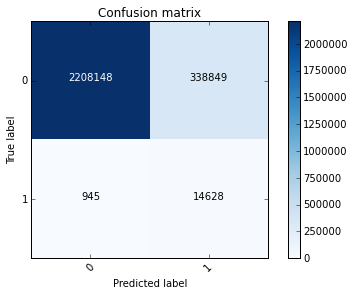

In [43]:
show_metrics(y_pred_feat2, y_test)

model log loss:0.290106144481


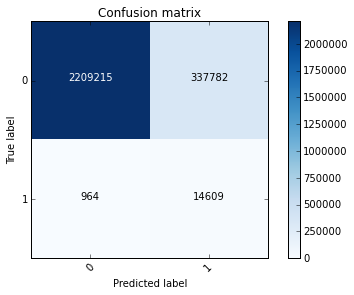

In [44]:
show_metrics(y_pred_feat3, y_test)

In [62]:
df_2017_daily = pd.read_csv('/Users/fezhao/Projects/traffic_manager/data/df_2017_daily.csv', sep='|')

In [73]:
df_feat0 = pd.concat([df_2017_daily, pd.DataFrame(y_pred_feat0, columns=['pred'])], axis=1)
df_feat1 = pd.concat([df_2017_daily, pd.DataFrame(y_pred_feat1, columns=['pred'])], axis=1)
df_feat2 = pd.concat([df_2017_daily, pd.DataFrame(y_pred_feat2, columns=['pred'])], axis=1)
df_feat3 = pd.concat([df_2017_daily, pd.DataFrame(y_pred_feat3, columns=['pred'])], axis=1)

In [76]:
print(df_feat0[df_feat0.pred<0.5].res_count.sum() * 1.0/df_feat0.res_count.sum())
print(df_feat1[df_feat1.pred<0.5].res_count.sum() * 1.0/df_feat1.res_count.sum())
print(df_feat2[df_feat2.pred<0.5].res_count.sum() * 1.0/df_feat2.res_count.sum())
print(df_feat3[df_feat3.pred<0.5].res_count.sum() * 1.0/df_feat3.res_count.sum())

0.0686577561061
0.0498497975532
0.0464103792068
0.0474117288519


In [84]:
print(df_feat0[df_feat0.pred<0.5].list_count.sum() * 1.0/df_feat0.list_count.sum())
print(df_feat1[df_feat1.pred<0.5].list_count.sum() * 1.0/df_feat1.list_count.sum())
print(df_feat2[df_feat2.pred<0.5].list_count.sum() * 1.0/df_feat2.list_count.sum())
print(df_feat3[df_feat3.pred<0.5].list_count.sum() * 1.0/df_feat3.list_count.sum())

0.294349115796
0.316986500326
0.323075957939
0.330052404731


In [85]:
print(df_feat0[df_feat0.pred<0.5].list_count.sum() *1.0/ df_feat0[df_feat0.pred<0.5].res_count.sum())
print(df_feat1[df_feat1.pred<0.5].list_count.sum() *1.0/ df_feat0[df_feat1.pred<0.5].res_count.sum())
print(df_feat2[df_feat2.pred<0.5].list_count.sum() *1.0/ df_feat0[df_feat2.pred<0.5].res_count.sum())
print(df_feat3[df_feat3.pred<0.5].list_count.sum() *1.0/ df_feat0[df_feat3.pred<0.5].res_count.sum())

1255607.94864
1862337.09782
2038780.4015
2038816.01194


Conclusion:

 - The models are better than the Joe's method, if we assume that the sample performance can be generalized to the whole polulation. Joe's result is 5% res count lost w.r.t. 24% list count reducation.
 - The feat3 model is the best since the ratio between block list_count and block reservation_count is the largest. Take feat3 model for example, that means we reduce 2,038,816 list counts while lose 1 res count. However, is it beneficial?
 - Next use the res count as the instance weight to retrain the model
 - Better understand the false negative (blocked res count instance)